# 12-Class SSVEP EEG Dataset - Classification Using Convolutional Neural Network
User-Dependent Training using Magnitude Spectrum Features and Complex Spectrum Features
(10-Fold Cross-validation)

Following implementation is an asynchronous SSVEP BCI using Convolutional Neural Network classification for 1 second data length.

Reference Paper: [Comparing user-dependent and user-independent training of CNN for SSVEP BCI](https://iopscience.iop.org/article/10.1088/1741-2552/ab6a67)


In [1]:
# 12-Class SSVEP EEG Dataset - Classification Using Convolutional Neural Network

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

sys.path.insert(0, os.path.abspath('..'))

# import warnings
import numpy as np
import numpy.matlib as npm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.losses import categorical_crossentropy
from scripts import ssvep_utils as su

# warnings.filterwarnings('ignore')

def get_training_data(features_data, input_time_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1],
                                               features_data.shape[2],
                                               features_data.shape[3] * features_data.shape[4]))
    input_time_data = np.reshape(input_time_data, (input_time_data.shape[0], input_time_data.shape[1],
                                                   input_time_data.shape[2],
                                                   input_time_data.shape[3] * input_time_data.shape[4]))

    train_data = features_data[:, :, 0, :].T
    time_data = input_time_data[:, :, 0, :].T

    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])
    for target in range(1, input_time_data.shape[2]):
        time_data = np.vstack([time_data, np.squeeze(input_time_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
    time_data = np.reshape(time_data, (time_data.shape[0], time_data.shape[1], time_data.shape[2]))

    total_epochs_per_class = features_data.shape[3]
    features_data = []
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = (npm.repmat(class_labels, total_epochs_per_class, 1).T).ravel()
    labels = to_categorical(labels)

    return train_data, time_data, labels


def train_CNN_cross_val_predict(train_data, time_data, labels, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True)
    kf.get_n_splits(train_data)
    cv_acc = np.zeros((num_folds, 1))
    fold = -1

    fig1 = plt.figure(1)
    ax1 = fig1.subplots()
    fig2 = plt.figure(2)
    ax2 = fig2.subplots()

    for train_index, test_index in kf.split(train_data):
        x_tr, x_ts = train_data[train_index], train_data[test_index]
        time_data_train, time_data_test = time_data[train_index], time_data[test_index]
        y_tr, y_ts = labels[train_index], labels[test_index]
        input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
        input_shape_time = np.array([time_data_train.shape[1], time_data_train.shape[2]])

        fold = fold + 1

        model = su.CNN_model(input_shape, input_shape_time, CNN_PARAMS)

        sgd = optimizers.SGD(lr=CNN_PARAMS['learning_rate'],
                             decay=CNN_PARAMS['lr_decay'],
                             momentum=CNN_PARAMS['momentum'],
                             nesterov=False)

        model.compile(optimizer=sgd,
                      loss=categorical_crossentropy,
                      metrics=["accuracy"])

        history = model.fit(x=[x_tr, time_data_train], y=y_tr, batch_size=CNN_PARAMS['batch_size'],
                            epochs=CNN_PARAMS['epochs'], verbose=0)

        ax1.plot(history.epoch, history.history['loss'])
        ax2.plot(history.epoch, history.history['accuracy'])
        # plt.title('train loss')
        # plt.plot(history.epoch, history.history['loss'])
        # plt.show()
        # plt.title('train accuracy')
        # plt.plot(history.epoch, history.history['accuracy'])
        # plt.show()

        score = model.evaluate([x_ts, time_data_test], y_ts, verbose=2)
        cv_acc[fold, :] = score[1] * 100
        print(f'cv{fold + 1}:{score[1] * 100:.2f}%', end=" ")

    ax1.set_title('train loss')
    ax2.set_title('train accuracy')
    plt.show()

    return cv_acc

In [2]:
data_path = os.path.abspath('../data')

CNN_PARAMS = {
    'batch_size': 64,
    # 'epochs': 50,
    'epochs': 300,
    'droprate': 0.25,
    'learning_rate': 0.0005,
    'lr_decay': 0.0005 / 315,
    # 'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 8,
    'num_classes': 12}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

window_len = 1
shift_len = 1

all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()
mag_time_data = dict()
com_time_data = dict()

mcnn_training_data = dict()
ccnn_training_data = dict()

mcnn_results = dict()
ccnn_results = dict()

In [3]:

# Load Dataset and Segment
all_segmented_data = dict()
for subject in range(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject + 1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')

    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 256

    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segmented_data[f's{subject + 1}'] = su.get_segmented_epochs(filtered_data, window_len,
                                                                    shift_len, sample_rate)
# Feature Extraction
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject], mag_time_data[subject] = su.magnitude_spectrum_features(
        all_segmented_data[subject],
        FFT_PARAMS)
    complex_spectrum_features[subject], com_time_data[subject] = su.complex_spectrum_features(
        all_segmented_data[subject],
        FFT_PARAMS)

for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()

    train_data, m_time_data, labels = get_training_data(magnitude_spectrum_features[subject], mag_time_data[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['time_data'] = m_time_data
    mcnn_training_data[subject]['label'] = labels

    train_data, c_time_data, labels = get_training_data(complex_spectrum_features[subject], com_time_data[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['time_data'] = c_time_data
    ccnn_training_data[subject]['label'] = labels


MCNN - Subject: s1
3/3 - 0s - loss: 1.1977 - accuracy: 0.6806
cv1:68.06% 3/3 - 0s - loss: 0.8796 - accuracy: 0.6944
cv2:69.44% 3/3 - 0s - loss: 0.9028 - accuracy: 0.7222
cv3:72.22% 3/3 - 0s - loss: 1.0558 - accuracy: 0.6806
cv4:68.06% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A289EF430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s

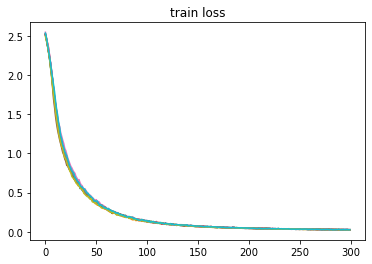

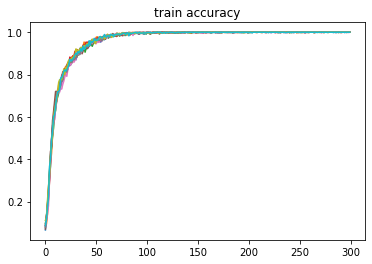


Accuracy: 69.861111%

MCNN - Subject: s2
3/3 - 0s - loss: 2.0865 - accuracy: 0.4028
cv1:40.28% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A3039F8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 1.7357 - accuracy: 0.4722
cv2:47.22% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

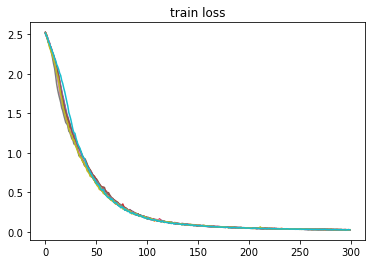

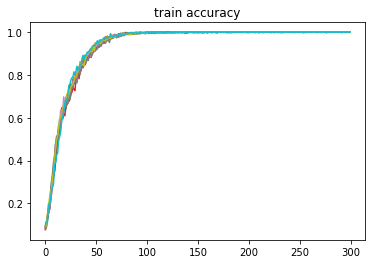


Accuracy: 39.305556%

MCNN - Subject: s3
3/3 - 0s - loss: 0.3602 - accuracy: 0.9028
cv1:90.28% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A59ABFD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.4223 - accuracy: 0.8750
cv2:87.50% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

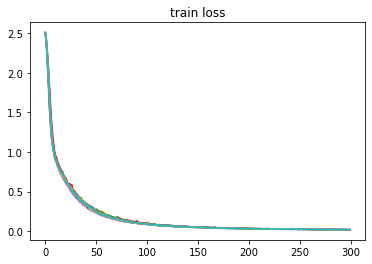

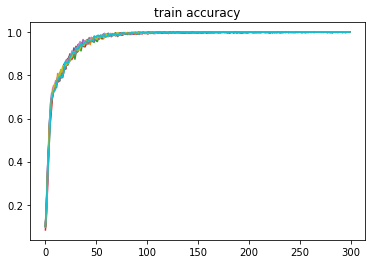


Accuracy: 85.416667%

MCNN - Subject: s4
3/3 - 0s - loss: 0.1216 - accuracy: 0.9722
cv1:97.22% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A674EC0D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.3103 - accuracy: 0.9167
cv2:91.67% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

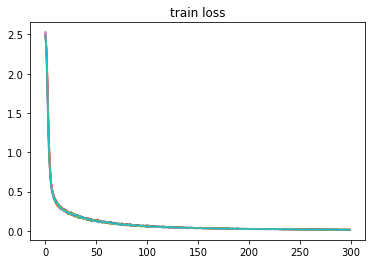

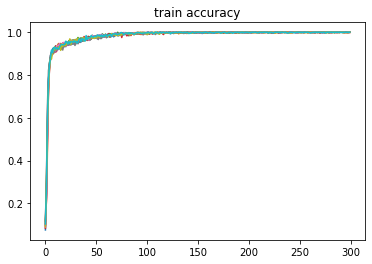


Accuracy: 93.194445%

MCNN - Subject: s5
3/3 - 0s - loss: 0.1390 - accuracy: 0.9306
cv1:93.06% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A3853E940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.1420 - accuracy: 0.9583
cv2:95.83% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

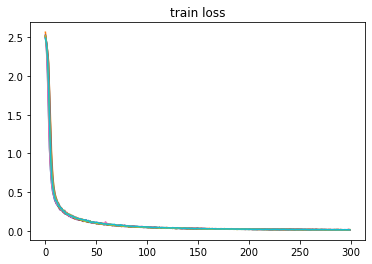

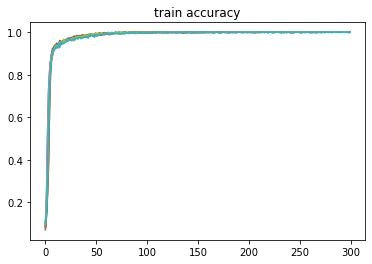


Accuracy: 95.833333%

MCNN - Subject: s6
3/3 - 0s - loss: 0.0325 - accuracy: 1.0000
cv1:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A47F75940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0524 - accuracy: 1.0000
cv2:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>

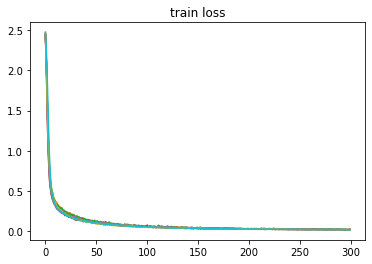

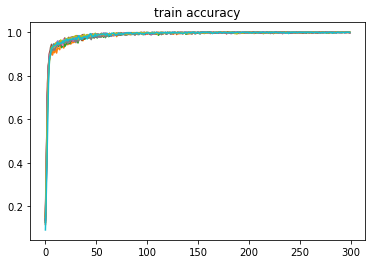


Accuracy: 97.083333%

MCNN - Subject: s7
3/3 - 0s - loss: 0.4604 - accuracy: 0.8611
cv1:86.11% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A59ABF700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.1904 - accuracy: 0.9306
cv2:93.06% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

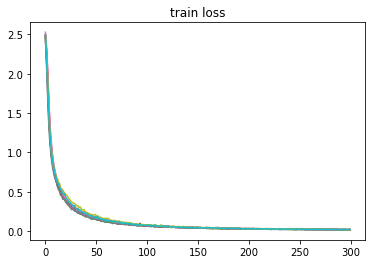

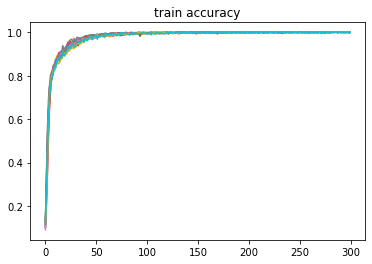


Accuracy: 92.361112%

MCNN - Subject: s8
3/3 - 0s - loss: 0.0399 - accuracy: 0.9861
cv1:98.61% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022ABDBC9EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0174 - accuracy: 1.0000
cv2:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.

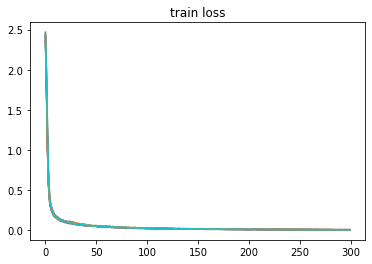

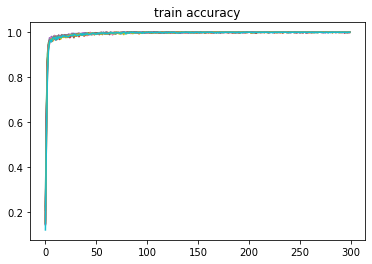


Accuracy: 98.472221%

MCNN - Subject: s9
3/3 - 0s - loss: 0.4058 - accuracy: 0.8611
cv1:86.11% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022AE72D7D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.3348 - accuracy: 0.9167
cv2:91.67% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.t

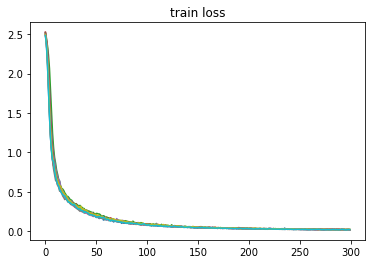

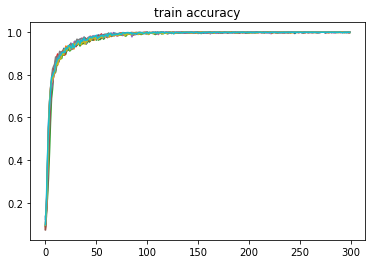


Accuracy: 90.416667%

MCNN - Subject: s10
3/3 - 0s - loss: 0.6046 - accuracy: 0.7778
cv1:77.78% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B026919D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.4033 - accuracy: 0.9167
cv2:91.67% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.

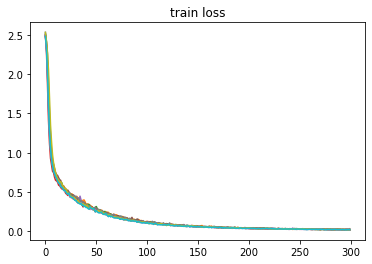

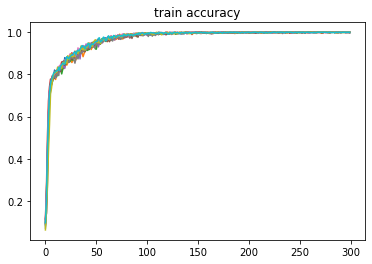


Accuracy: 80.555556%
Overall Accuracy MCNN - 84.25%


In [4]:

# M-CNN Training and Results
for subject in mcnn_training_data.keys():
    print(f'\nMCNN - Subject: {subject}')
    train_data = mcnn_training_data[subject]['train_data']
    train_time_data = mcnn_training_data[subject]['time_data']
    labels = mcnn_training_data[subject]['label']

    cv_acc = train_CNN_cross_val_predict(train_data, train_time_data, labels, 10)
    mcnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {mcnn_results[subject]:2f}%')

mcnn_overall_accuracy = np.mean(np.fromiter(mcnn_results.values(), dtype=float))
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')


CCNN - Subject: s1
3/3 - 0s - loss: 0.4921 - accuracy: 0.9167
cv1:91.67% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B06067820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.6787 - accuracy: 0.7778
cv2:77.78% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000

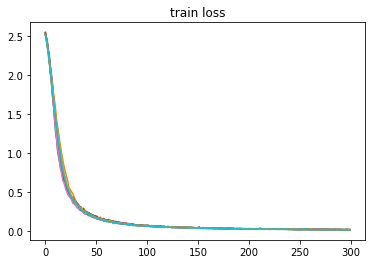

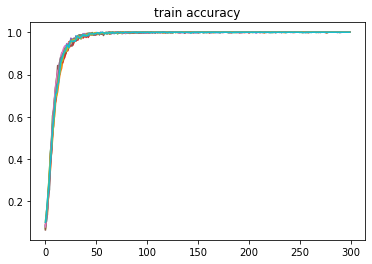


Accuracy: 83.61%

CCNN - Subject: s2
3/3 - 0s - loss: 1.1535 - accuracy: 0.6389
cv1:63.89% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022A5C3708B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.9391 - accuracy: 0.6944
cv2:69.44% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_

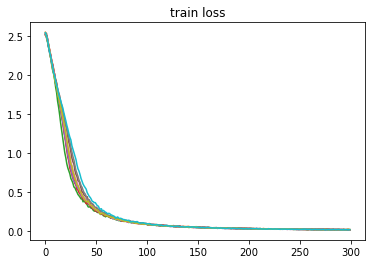

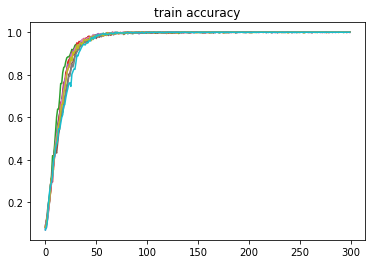


Accuracy: 65.69%

CCNN - Subject: s3
3/3 - 0s - loss: 0.1226 - accuracy: 0.9722
cv1:97.22% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B3CC3E1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0856 - accuracy: 0.9861
cv2:98.61% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_

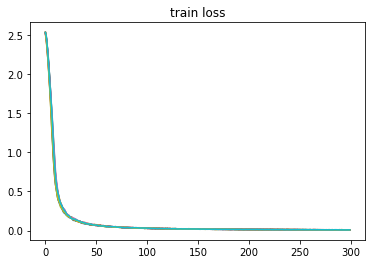

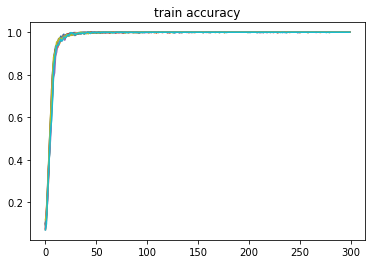


Accuracy: 98.06%

CCNN - Subject: s4
3/3 - 0s - loss: 0.0473 - accuracy: 0.9861
cv1:98.61% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B3AF23EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0396 - accuracy: 0.9861
cv2:98.61% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_

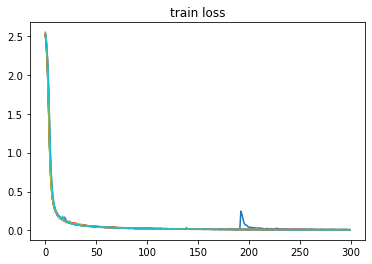

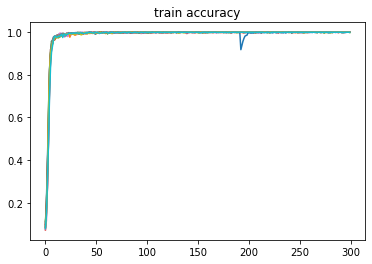


Accuracy: 98.75%

CCNN - Subject: s5
3/3 - 0s - loss: 0.0211 - accuracy: 1.0000
cv1:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B2FE37AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0112 - accuracy: 1.0000
cv2:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.tes

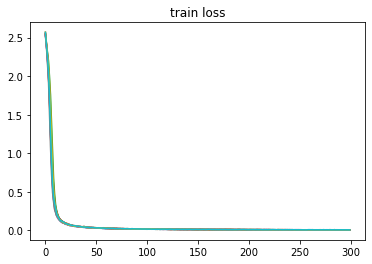

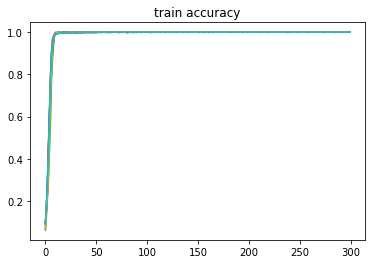


Accuracy: 99.72%

CCNN - Subject: s6
3/3 - 0s - loss: 0.0083 - accuracy: 1.0000
cv1:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B95EF8C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0207 - accuracy: 1.0000
cv2:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.tes

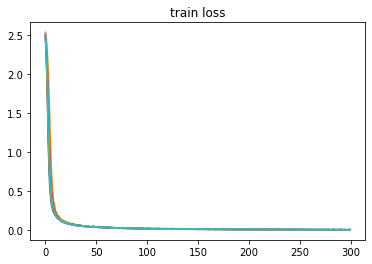

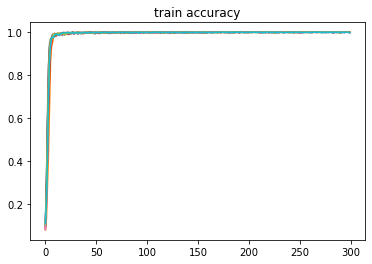


Accuracy: 99.72%

CCNN - Subject: s7
3/3 - 0s - loss: 0.1087 - accuracy: 0.9583
cv1:95.83% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B6902FC10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.1246 - accuracy: 0.9444
cv2:94.44% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_

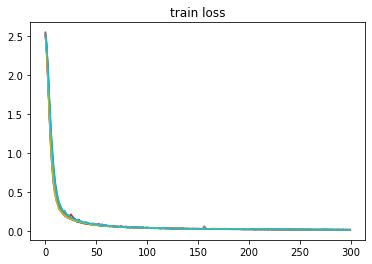

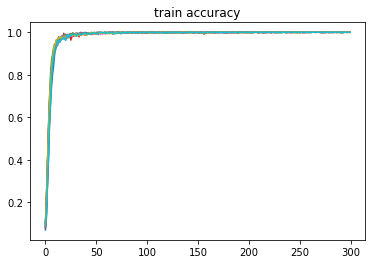


Accuracy: 96.11%

CCNN - Subject: s8
3/3 - 0s - loss: 0.0402 - accuracy: 0.9861
cv1:98.61% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B0608D040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.0319 - accuracy: 1.0000
cv2:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test

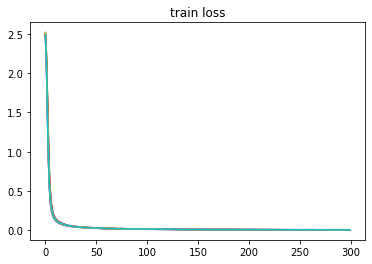

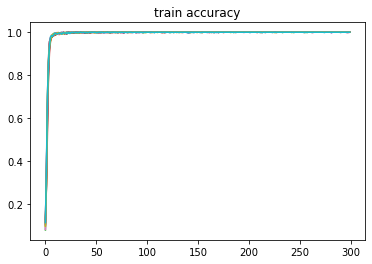


Accuracy: 99.58%

CCNN - Subject: s9
3/3 - 0s - loss: 0.0361 - accuracy: 1.0000
cv1:100.00% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022B5AD3FEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.1467 - accuracy: 0.9722
cv2:97.22% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test

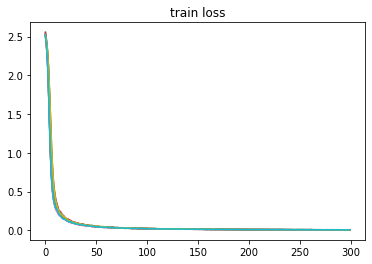

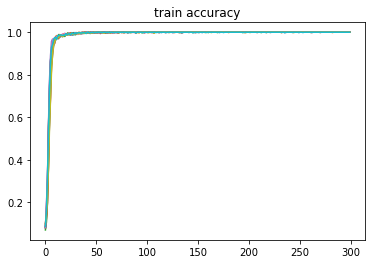


Accuracy: 98.06%

CCNN - Subject: s10
3/3 - 0s - loss: 0.2674 - accuracy: 0.9444
cv1:94.44% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x0000022C02F19670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 - 0s - loss: 0.3432 - accuracy: 0.9028
cv2:90.28% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test

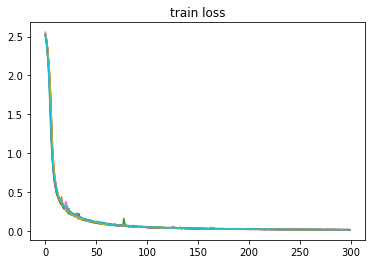

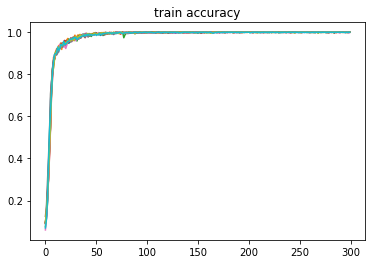


Accuracy: 92.78%
Overall Accuracy CCNN - 93.21%


In [5]:

# C-CNN Training and Results
for subject in ccnn_training_data.keys():
    print(f'\nCCNN - Subject: {subject}')
    train_data = ccnn_training_data[subject]['train_data']
    train_time_data = ccnn_training_data[subject]['time_data']
    labels = ccnn_training_data[subject]['label']

    cv_acc = train_CNN_cross_val_predict(train_data, train_time_data, labels, 10)
    ccnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {ccnn_results[subject]:.2f}%')

ccnn_overall_accuracy = np.mean(np.fromiter(ccnn_results.values(), dtype=float))
print(f'Overall Accuracy CCNN - {ccnn_overall_accuracy:.2f}%')

        mcnn       ccnn
0  69.861111  83.611112
1  39.305556  65.694445
2  85.416667  98.055555
3  93.194445  98.749999
4  95.833333  99.722222
5  97.083333  99.722222
6  92.361112  96.111110
7  98.472221  99.583333
8  90.416667  98.055555
9  80.555556  92.777777
Overall Accuracy MCNN - 84.25%
Overall Accuracy CCNN - 93.21%


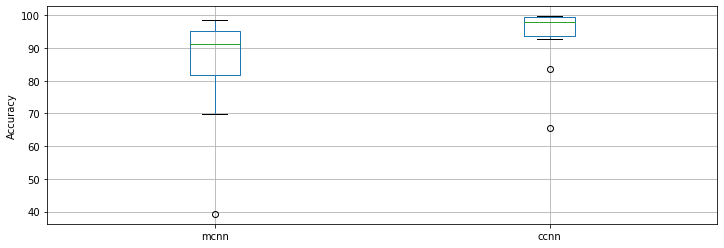

In [6]:

# Summary
results = pd.DataFrame({'mcnn': np.fromiter(mcnn_results.values(), dtype=float),
                        'ccnn': np.fromiter(ccnn_results.values(), dtype=float)})

print(results)
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')
print(f'Overall Accuracy CCNN - {ccnn_overall_accuracy:.2f}%')

results.boxplot(figsize=(12, 4), column=['mcnn', 'ccnn'])
plt.ylabel('Accuracy')
plt.show()

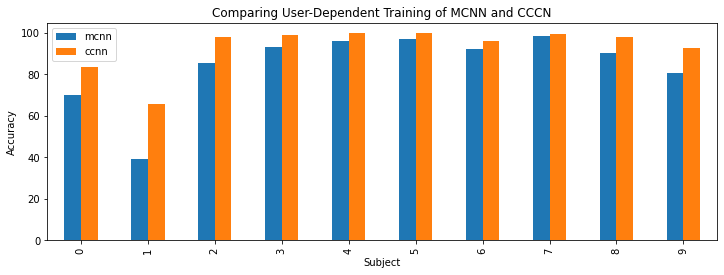

In [7]:

results.plot.bar(figsize=(12, 4), title='Comparing User-Dependent Training of MCNN and CCCN')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()